In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux;

In [2]:
#Hyperparameters
n = 500
N = 1200
σₐ = 0.002
k_range = 12
k_list = [i for i in 1:k_range];

In [3]:
#Functions
function plot_data(data,classes)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    bₕ = bₕ
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

function sigmoid(x::Array{Float64}, a=10000)
    return 1.0 ./ (1.0 .+ a.*exp.(-x))
end

function hardσ(x, a=2)
    max(0, min(1.0, a * x + 0.5))
end
    
#function sigmoid(x::Float64, a=1)
    #return 1.0 / 1.0 + a*exp(-x)
#end

mₖ(k) = k*4 + 1

#Test out the unpack method
k = 5
m = mₖ(k)
θtest = [i for i=1:m]
a,b,c,d = unpack(θtest,k)

([1 6; 2 7; … ; 4 9; 5 10], [11, 12, 13, 14, 15], [16 17 … 19 20], 21)

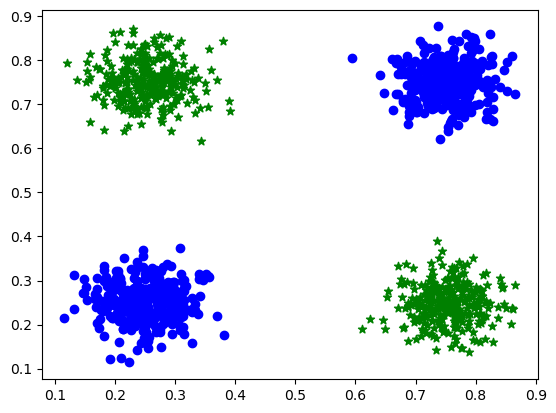

In [4]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.25, 0.75]
    μ₃ = [0.75, 0.75]
    μ₄ = [0.75, 0.25]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

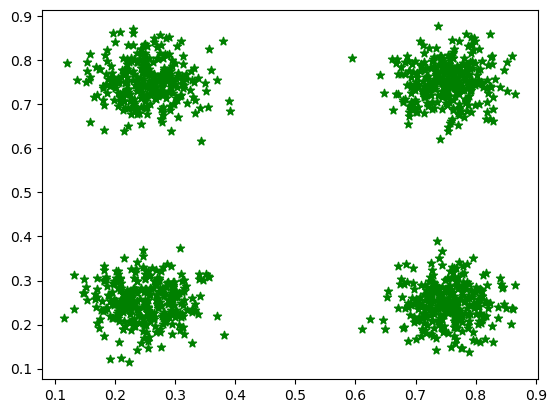

In [5]:
#Bayesian Neural Net
function G(x, Θ::AbstractVector, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    W₁, b₁, W₂, b₂ = unpack(Θ,k)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, [b₂], hardσ))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 100.0::Float64
    
    # Create the weight and bias vector.
    k ~ uniform_discrete(1,k_range)
    #k ~ k_count(1,0.5,1)
    #k=2
    m = mₖ(k)
    μ = zeros(m)
    Σ = Diagonal([σₖ for i=1:m])
    Θ ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    #Return Network Scores for X
    scores = G(x,Θ,k)
    #scores = sigmoid(nn_out,10000)
    
    #Logistic Regression Likelihood
    y = zeros(length(x[1,:])) #Array to fill with class labels
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end
    return y
end;

predictions = classifier(data)
plot_data(data_raw,predictions)

In [6]:
#Register Observed Data
obs = choicemap()::ChoiceMap
for j in 1:length(classes)
    obs[(:y, j)] = classes[j]
end;
#print(obs)

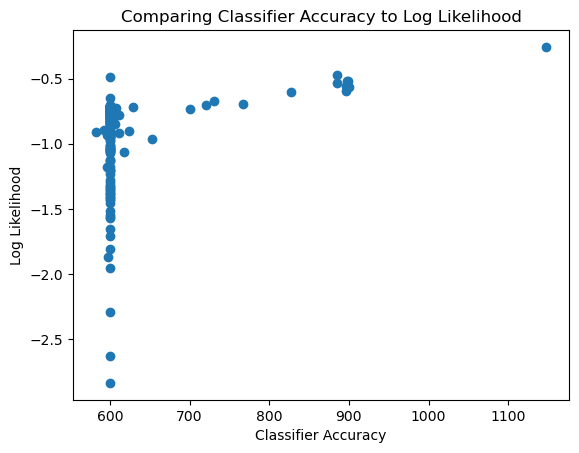

7

In [7]:
#Plot of Log Likelihood Scores
scores = []
accs = []
(best_trace,) = generate(classifier, (data,), obs)
best_score = get_score(best_trace)/length(classes)
best_Θ = best_trace[:Θ]
best_k = best_trace[:k]
print(best_k)

best_pred_y = G(data,best_Θ,best_k)
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([best_trace[(:y,i)] == best_pred_labels[i] for i=1:length(classes)])/length(classes)

for i in 1:100000
    (trace,) = generate(classifier, (data,), obs)
    Θ = trace[:Θ]
    k = trace[:k]
    #k=2
    pred_y = G(data,Θ,k)
    pred_labels = data_labeller(pred_y)
    #print(pred_labels)
    acc = sum([trace[(:y,i)] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)/length(classes)
    if acc > best_acc
        best_score = score
        best_trace = trace
        best_acc = acc
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
end

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

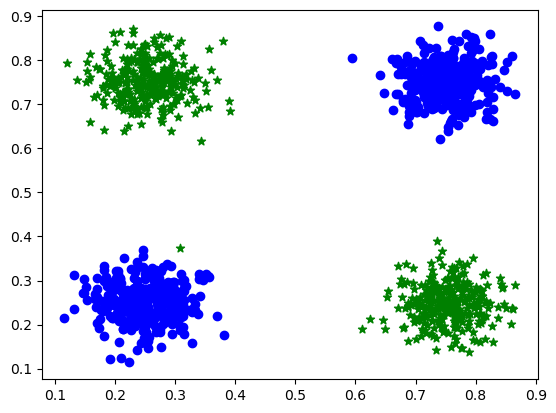

7


In [8]:
test_scores = sigmoid(G(data,best_Θ,best_k),1)
predictions = data_labeller(test_scores)
plot_data(data_raw,best_pred_labels)
#print(best_Θ)
#print(best_acc)
println(best_k)

In [9]:
#Homebrew MCMC
iterations = 200000
burnin = 2000

#Make initial trace
(trace,) = generate(classifier, (data,), obs)
traces = []
accepted = []
scores = []
for i=1:iterations
    (trace2,) = generate(classifier, (data,), obs)
    score1 = exp(get_score(trace)/length(classes))
    score2 = exp(get_score(trace2)/length(classes))
    
    score = score2/score1
    
    if score > 1
        trace = trace2
        acc = 1
        push!(scores, score2)
    else
        if score > rand(Uniform(0,1))
            trace = trace2
            acc = 1
            push!(scores, score2)
        else
            acc = 0
            push!(scores, score1)
        end
    end
    if i%10000 == 0    
        println("Epoch $i Acceptance Prob: $(sum(accepted)/length(accepted))")
    end
    push!(accepted, acc)
    if i%1 == 0
        push!(traces, trace)
    end
end

print(sum(accepted)/length(accepted))

Epoch 10000 Acceptance Prob: 0.0018001800180018
Epoch 20000 Acceptance Prob: 0.0019500975048752439
Epoch 30000 Acceptance Prob: 0.0017333911130371013
Epoch 40000 Acceptance Prob: 0.0016500412510312757
Epoch 50000 Acceptance Prob: 0.001500030000600012
Epoch 60000 Acceptance Prob: 0.0014666911115185253
Epoch 70000 Acceptance Prob: 0.001457163673766768
Epoch 80000 Acceptance Prob: 0.001412517656470706
Epoch 90000 Acceptance Prob: 0.00141112679029767
Epoch 100000 Acceptance Prob: 0.0014000140001400015
Epoch 110000 Acceptance Prob: 0.0013636487604432768
Epoch 120000 Acceptance Prob: 0.0014083450695422462
Epoch 130000 Acceptance Prob: 0.0014153955030423312
Epoch 140000 Acceptance Prob: 0.0014142958163986885
Epoch 150000 Acceptance Prob: 0.0014600097333982228
Epoch 160000 Acceptance Prob: 0.0014562591016193851
Epoch 170000 Acceptance Prob: 0.0014882440484944028
Epoch 180000 Acceptance Prob: 0.0014777859876999317
Epoch 190000 Acceptance Prob: 0.0014421128532255433
Epoch 200000 Acceptance Prob:

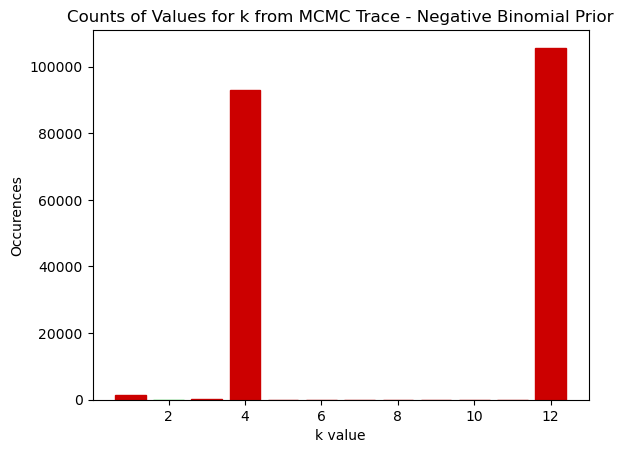

In [12]:
#Bar Plot of k estimates
ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from MCMC Trace - Negative Binomial Prior")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [11]:
#Metropolis-Hastings finally works!
function mh_inference(iters)
    (trace,) = generate(classifier, (data,), obs)
    acc = []
    traces = []
    for i=1:iters
        (trace, accepted) = mh(trace, select(:k,:Θ), check=false, observations=obs)
        push!(traces, trace)
        push!(acc, accepted)
        if i%10000 == 0
            #println(sum(accepted)/length(accepted))
        end
    end
    return traces, acc
end

traces, accepted = mh_inference(200000);

In [24]:
function U(trace)
    return(get_score(trace)/length(get_retval(trace)))
end

U(trace)

-0.7104425666015626